#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/6th_mini_project_1/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [ ]:
df_3 = joblib.load('/content/drive/MyDrive/df_3.pkl')
df_3.drop(columns=['Date'], inplace=True)
df_3

,Qty,WTI_Price,CustomerCount,Price,Weekend,Holiday,B_Friday,Total_sales,target
0,0.0,95.140000,0.0,8,0,1,0,0.0,8647.0
1,9853.0,95.140000,4422.0,8,0,0,0,78824.0,15153.0
2,8647.0,93.660000,4167.0,8,0,0,0,69176.0,15606.0
3,15153.0,93.480000,5341.0,8,1,0,0,121224.0,7900.0
4,15606.0,93.300000,5123.0,8,1,0,0,124848.0,7188.0
...,...,...,...,...,...,...,...,...,...
1145,7856.0,53.610000,3834.0,8,0,0,0,62848.0,10208.0
1146,8018.0,54.480000,3955.0,8,0,0,0,64144.0,12361.0
1147,10208.0,53.990000,4549.0,8,0,0,0,81664.0,10108.0
1148,12361.0,54.006667,4619.0,8,1,0,0,98888.0,10006.0


In [ ]:
df_12 = joblib.load('/content/drive/MyDrive/df_12.pkl')
df_12['target'] = df_12['Qty'].shift(-2)
df_12.dropna(inplace=True)
df_12
# x이게 target 만들어야함

,Qty,WTI_Price,Year,Month,Day,Autumn,Spring,Summer,Winter,target
0,0.0,95.140,2014,1,1,False,False,False,True,8879.0
1,9647.0,95.140,2014,1,2,False,False,False,True,7614.0
2,8879.0,93.660,2014,1,3,False,False,False,True,7124.0
3,7614.0,93.120,2014,1,6,False,False,False,True,8683.0
4,7124.0,93.310,2014,1,7,False,False,False,True,6731.0
...,...,...,...,...,...,...,...,...,...,...
816,7246.0,53.715,2017,2,20,False,False,False,True,8931.0
817,7374.0,54.020,2017,2,21,False,False,False,True,8643.0
818,8931.0,53.610,2017,2,22,False,False,False,True,10630.0
819,8643.0,54.480,2017,2,23,False,False,False,True,10618.0


In [ ]:
df_42 = joblib.load('/content/drive/MyDrive/df_42.pkl')
df_42.drop(columns=['Date'], inplace=True)
df_42

,Qty,CustomerCount,Year,Month,Day,Day_of_week,Day_of_week_2,isSummer,isWinter,target
0,76.0,4422,2014,1,2,3,5.0,0,1,78.0
1,74.0,4167,2014,1,3,4,6.0,0,1,88.0
2,78.0,5341,2014,1,4,5,0.0,0,1,65.0
3,88.0,5123,2014,1,5,6,1.0,0,1,78.0
4,65.0,3917,2014,1,6,0,2.0,0,1,73.0
...,...,...,...,...,...,...,...,...,...,...
1139,72.0,3834,2017,2,22,2,4.0,0,1,91.0
1140,98.0,3955,2017,2,23,3,5.0,0,1,105.0
1141,91.0,4549,2017,2,24,4,6.0,0,1,108.0
1142,105.0,4619,2017,2,25,5,0.0,0,1,78.0


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop([target], axis = 1)
    y = data.loc[:, target]

    col_names = list(x)

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (1024, 7, 8), (120, 7, 8))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

# model_lstm_03 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
#                          Dense(1)])
model_lstm_03 = Sequential([LSTM(32, input_shape = (timesteps, nfeat), return_sequences = True),
                    LSTM(16),
                    Dense(32, activation = 'relu'),
                    Dense(1)])

model_lstm_03.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             5376      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


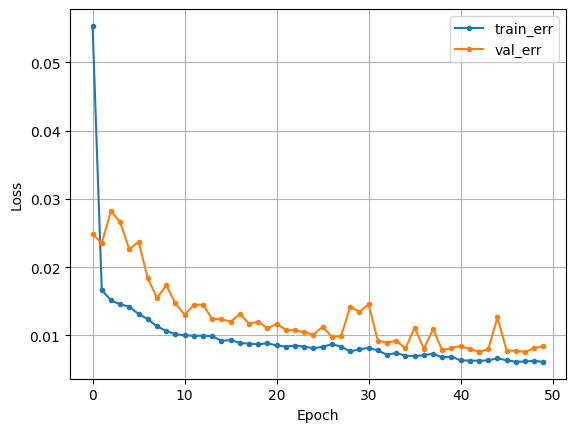

In [ ]:
model_lstm_03.compile(optimizer = 'adam', loss = 'mse')
hist = model_lstm_03.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_lstm_03.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 1s 6ms/step
MAE :  10.739148648579915
MAPE :  0.112194410361389
R2 :  0.6451940329228958


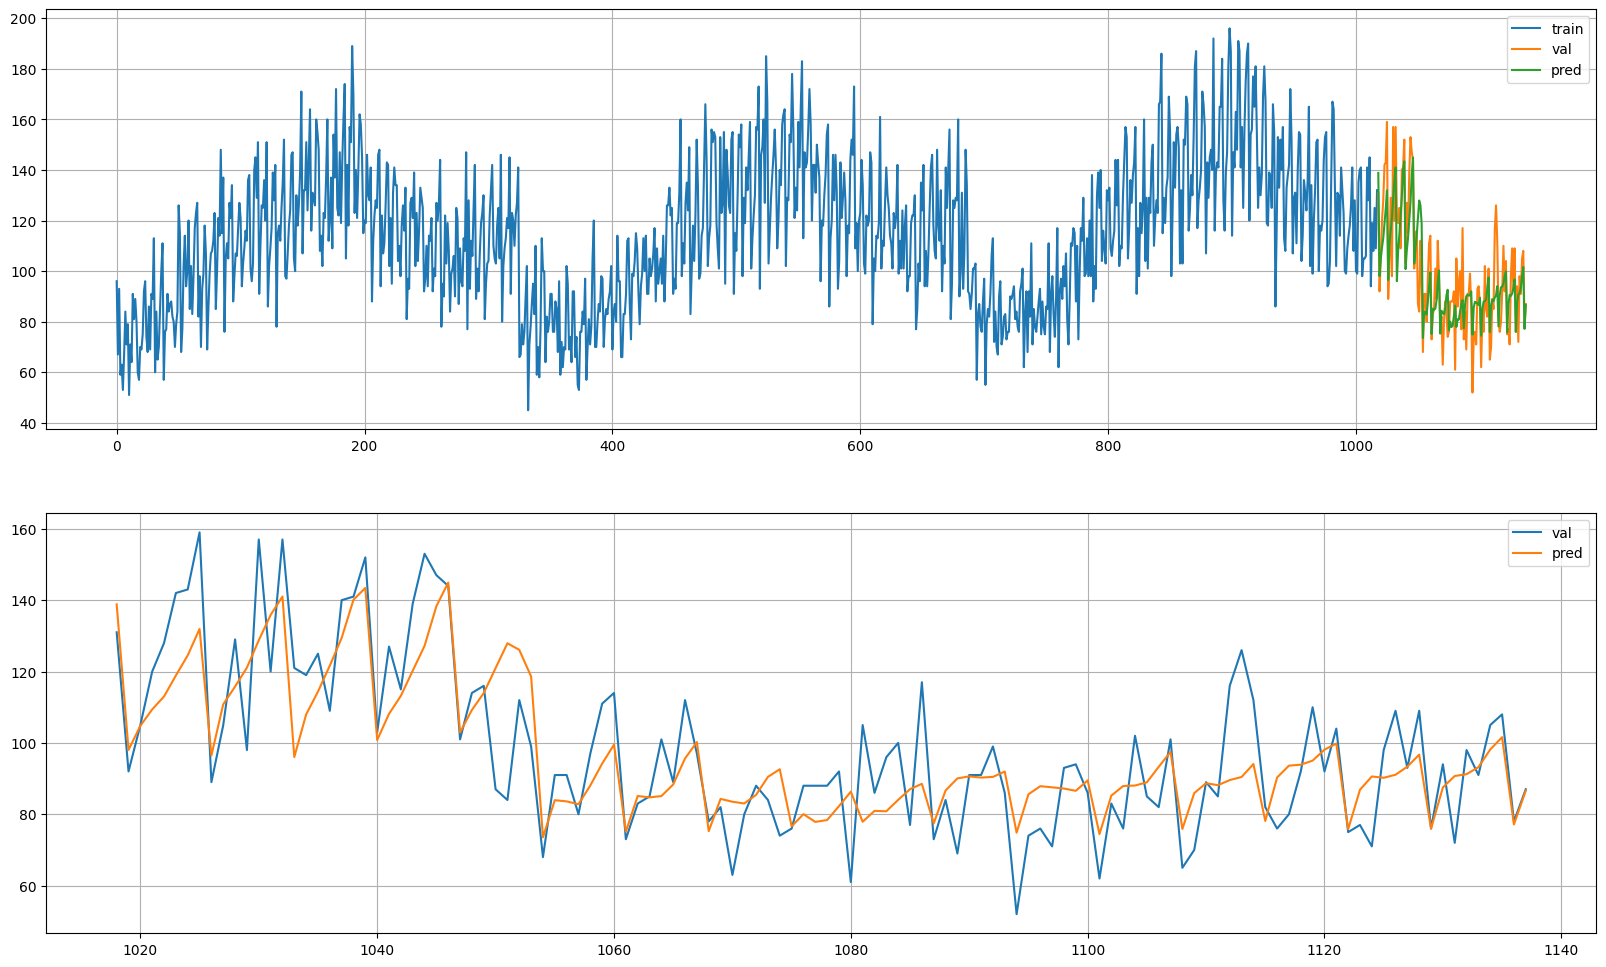

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 37106.0, (695, 7, 9), (120, 7, 9))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model_lstm_12 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model_lstm_12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 224       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 229 (916.00 Byte)
Trainable params: 229 (916.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


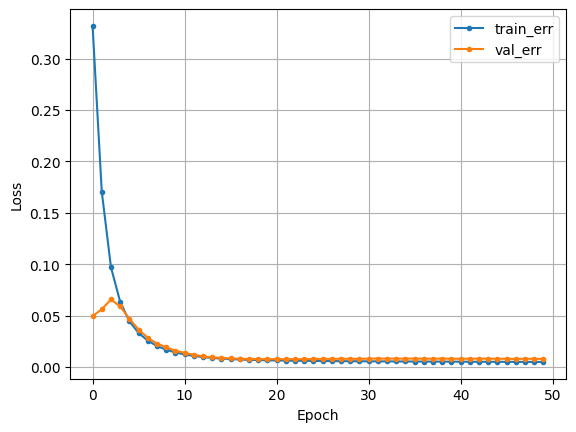

In [ ]:
model_lstm_12.compile(optimizer = 'adam', loss = 'mse')
hist = model_lstm_12.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_lstm_12.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 1s 5ms/step
MAE :  2650.2240091959634
MAPE :  0.25179228419896926
R2 :  -0.34893834379880273


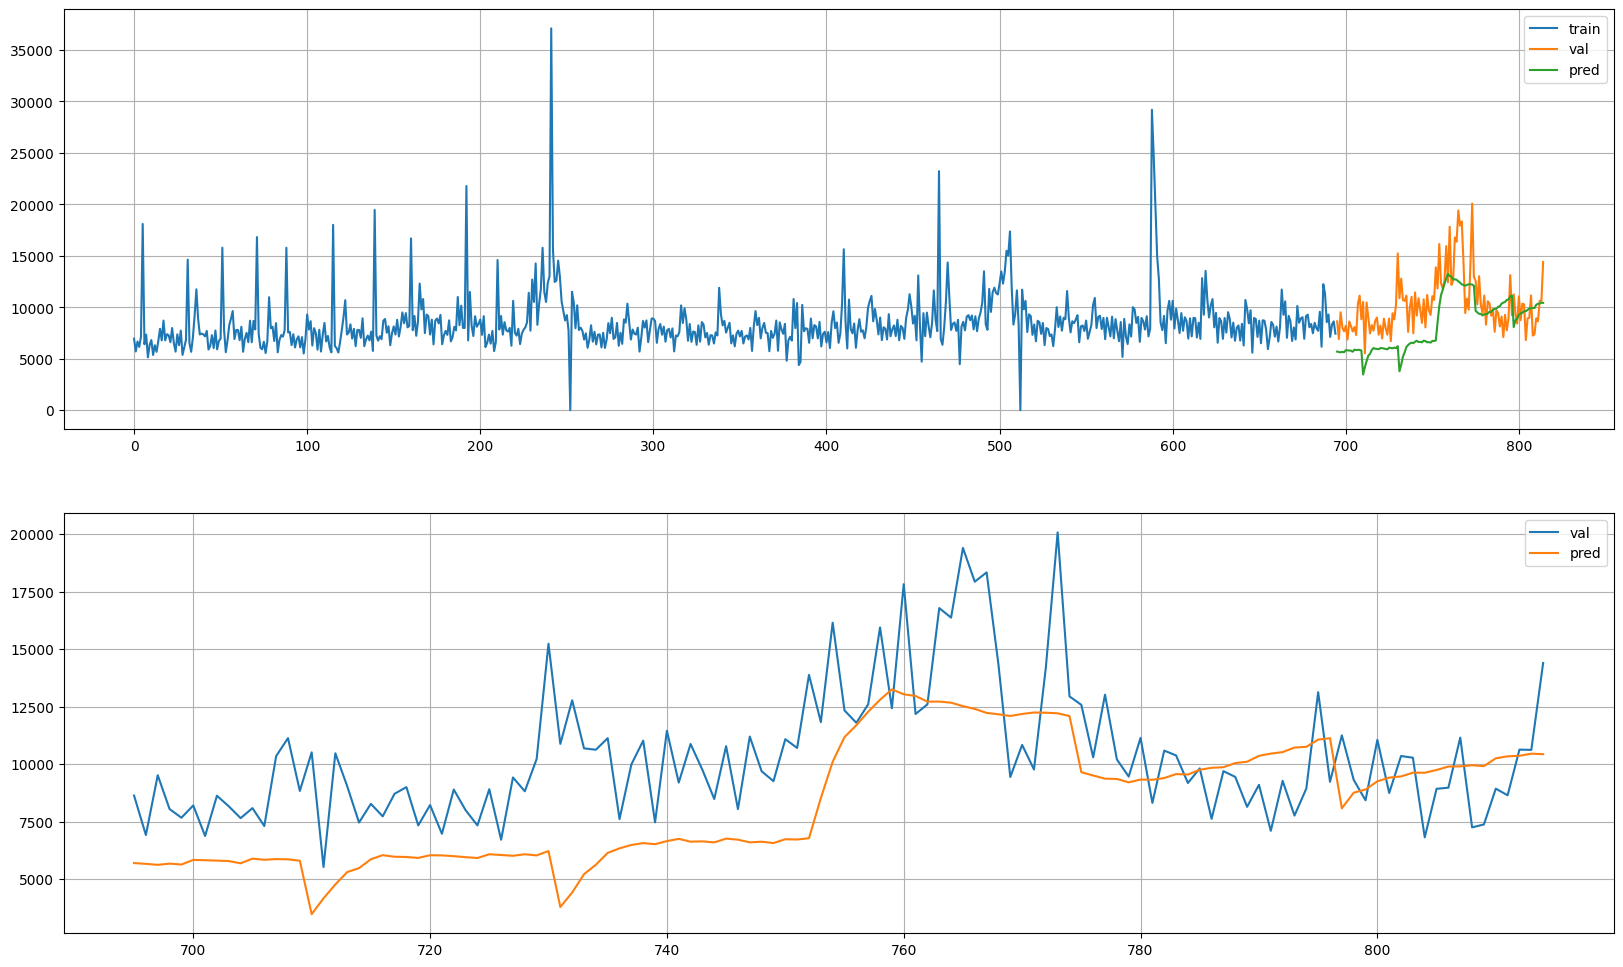

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1018, 7, 9), (120, 7, 9))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

# model_lstm_42 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
#                          Dense(1)])

model_lstm_42 = Sequential([
            LSTM(32, input_shape = (7, x_train.shape[2]),),
            Dense(32, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])
model_lstm_42.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6705 (26.19 KB)
Trainable params: 6705 (26.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


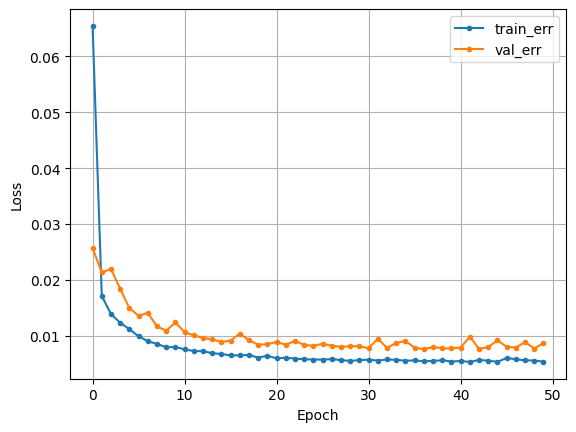

In [ ]:
model_lstm_42.compile(optimizer = 'adam', loss = 'mse')
hist = model_lstm_42.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_lstm_42.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  9.970717811584473
MAPE :  0.10228194306816228
R2 :  0.6917597806117515


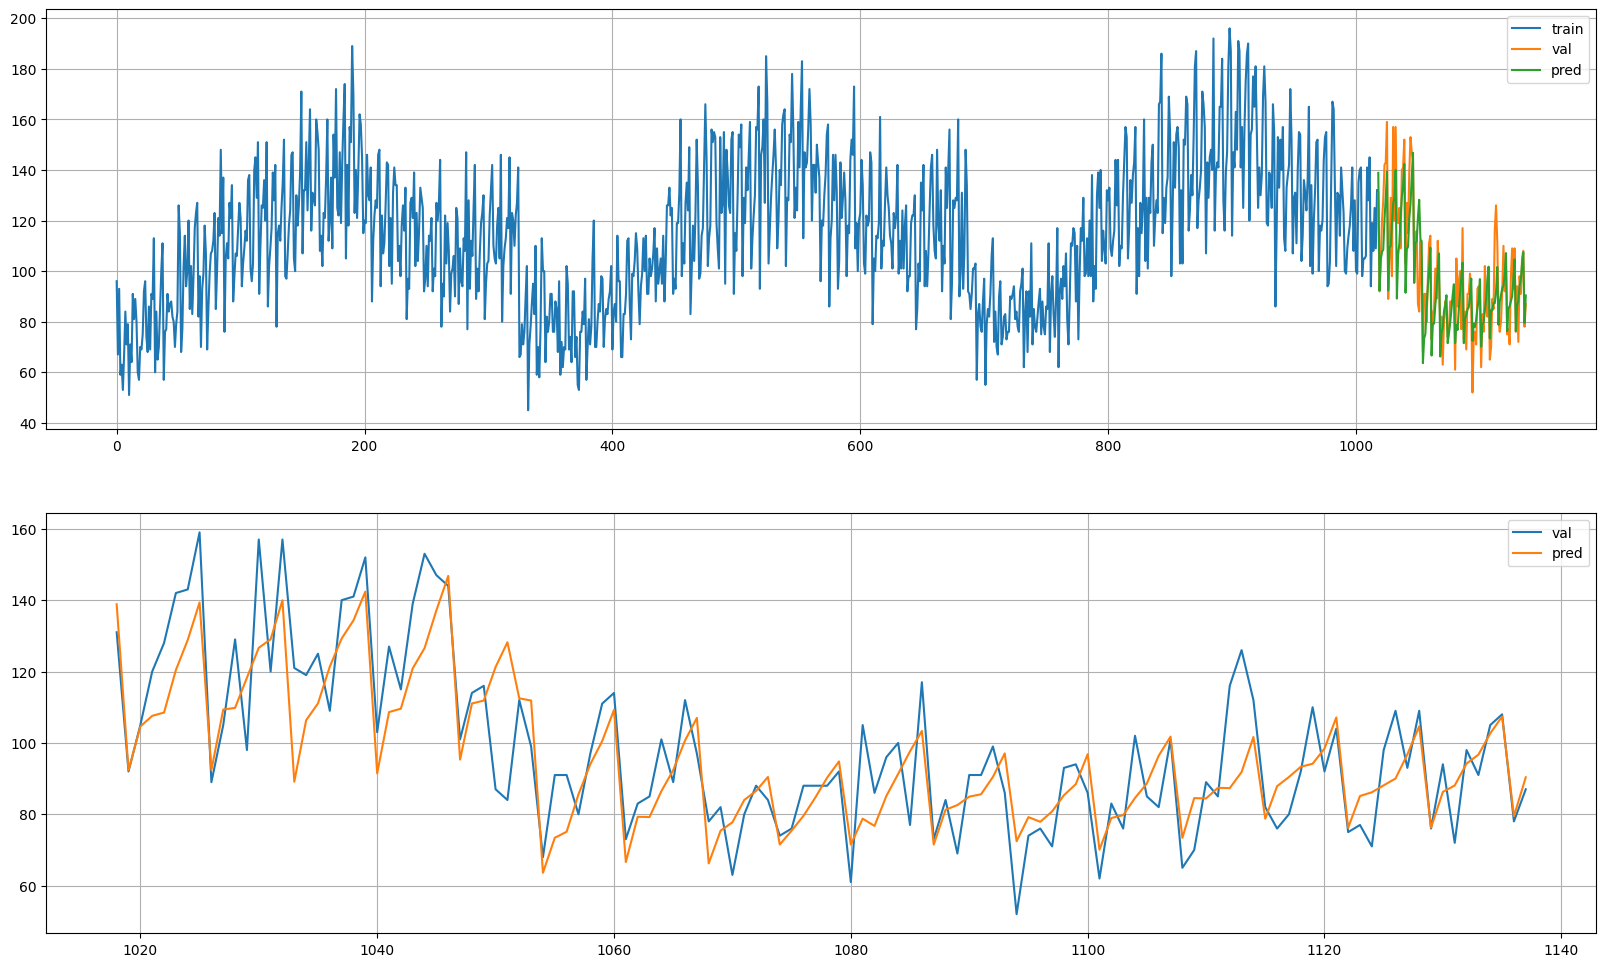

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (1024, 7, 8), (120, 7, 8))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model_cnn_03 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model_cnn_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              100       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


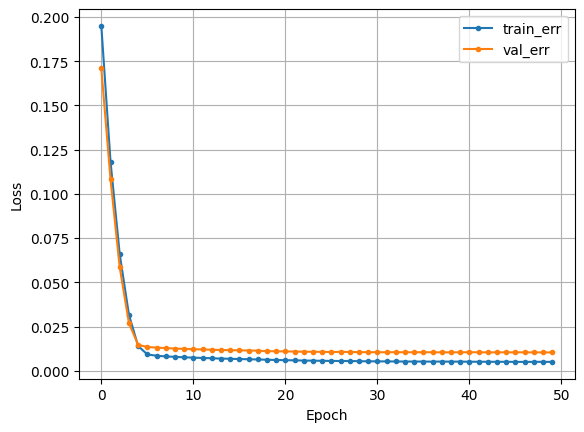

In [ ]:
model_cnn_03.compile(optimizer = 'adam', loss = 'mse')
hist = model_cnn_03.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_cnn_03.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  1917.2266723632813
MAPE :  4.3868197643766554e+17
R2 :  0.37603282192007437


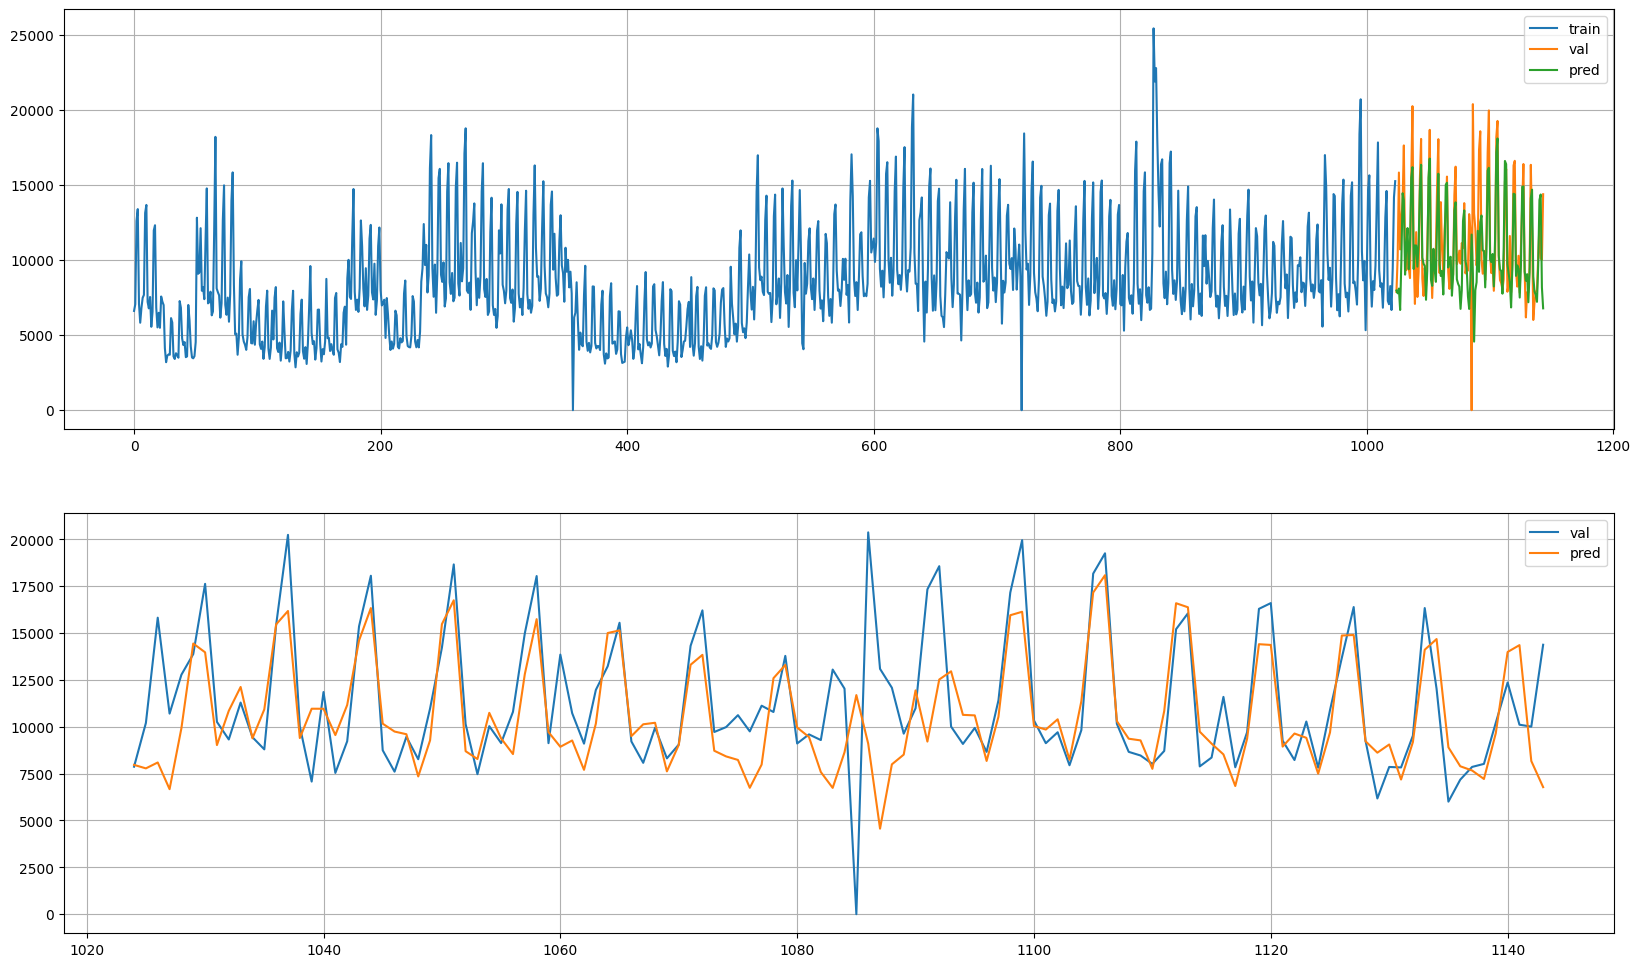

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 37106.0, (695, 7, 9), (120, 7, 9))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model_cnn_12 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model_cnn_12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              112       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 141 (564.00 Byte)
Trainable params: 141 (564.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


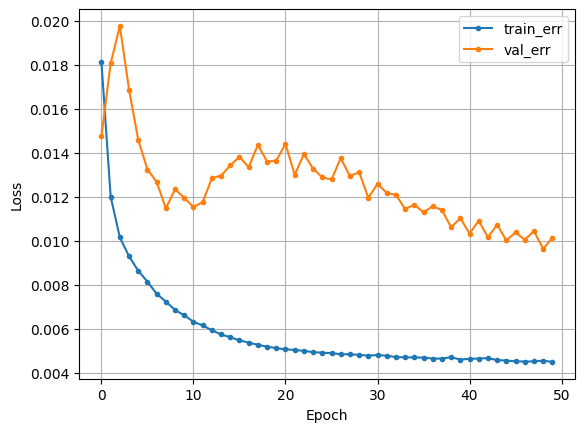

In [ ]:
model_cnn_12.compile(optimizer = 'adam', loss = 'mse')
hist = model_cnn_12.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_cnn_12.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  2374.167195638021
MAPE :  0.20802299862749193
R2 :  -0.2164058713120145


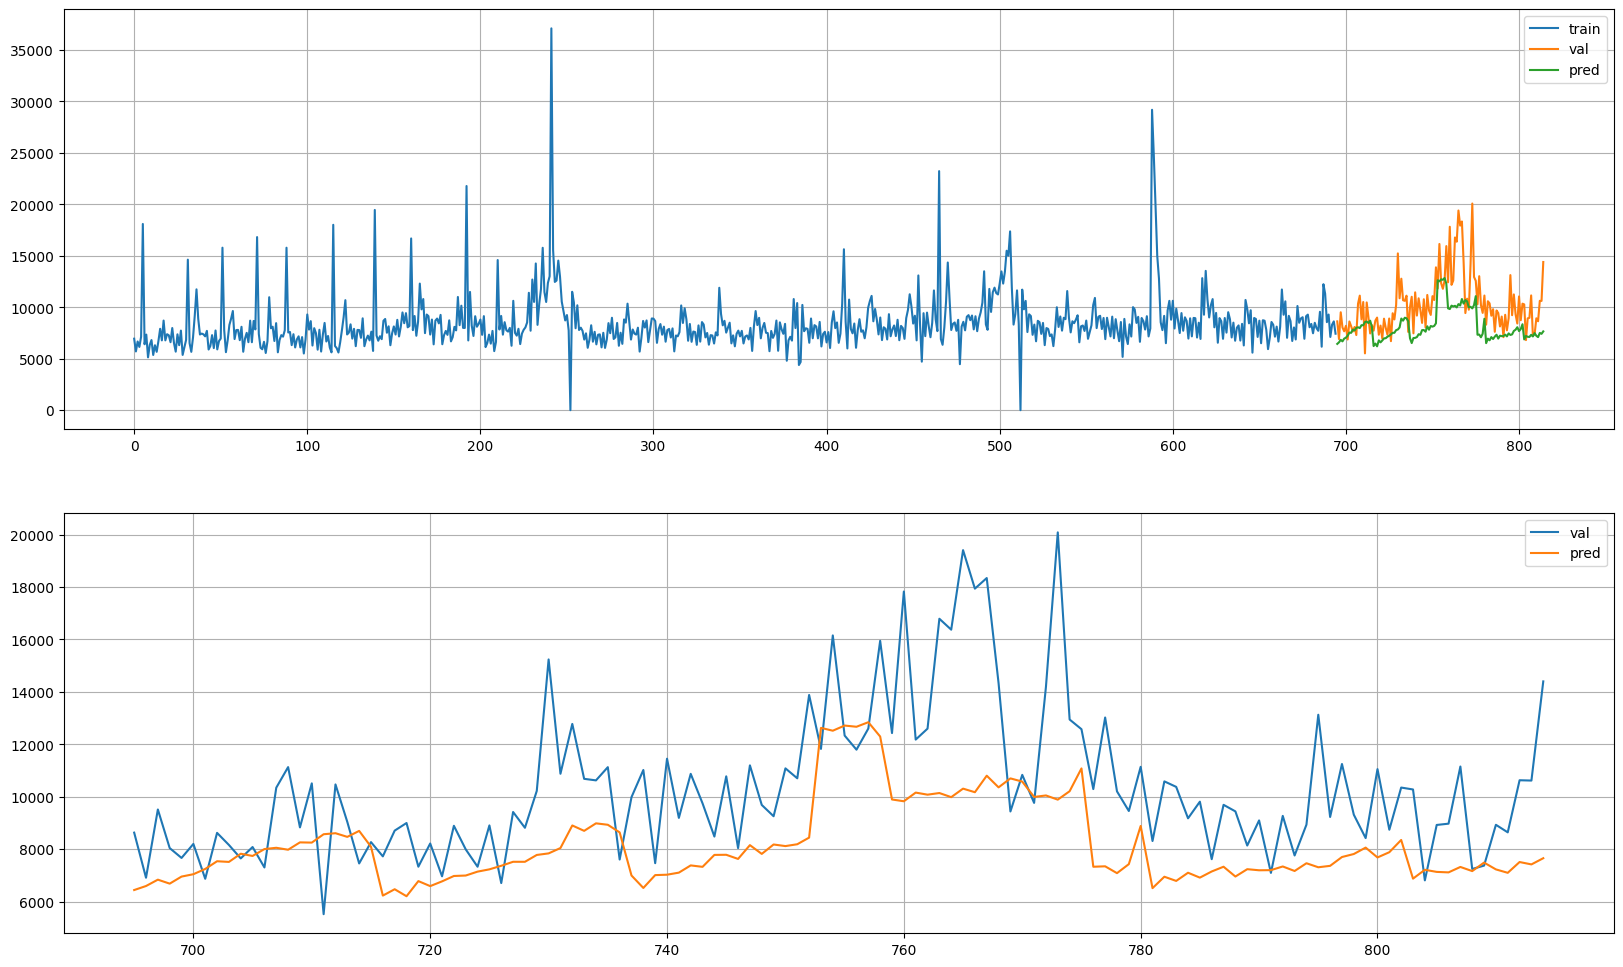

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1018, 7, 9), (120, 7, 9))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model_cnn_42 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model_cnn_42.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              112       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 141 (564.00 Byte)
Trainable params: 141 (564.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


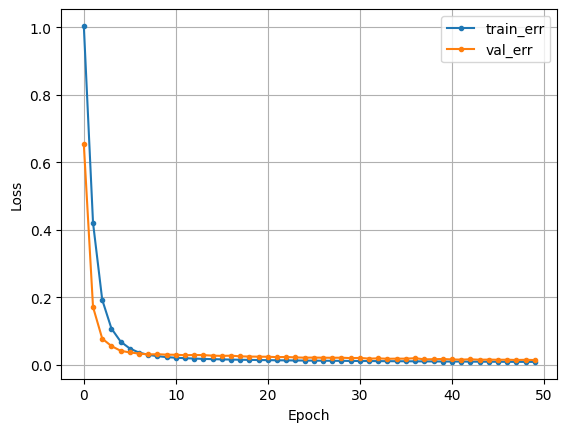

In [ ]:
model_cnn_42.compile(optimizer = 'adam', loss = 'mse')
hist = model_cnn_42.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_cnn_42.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  12.575439262390137
MAPE :  0.1360889833205688
R2 :  0.5201573936329917


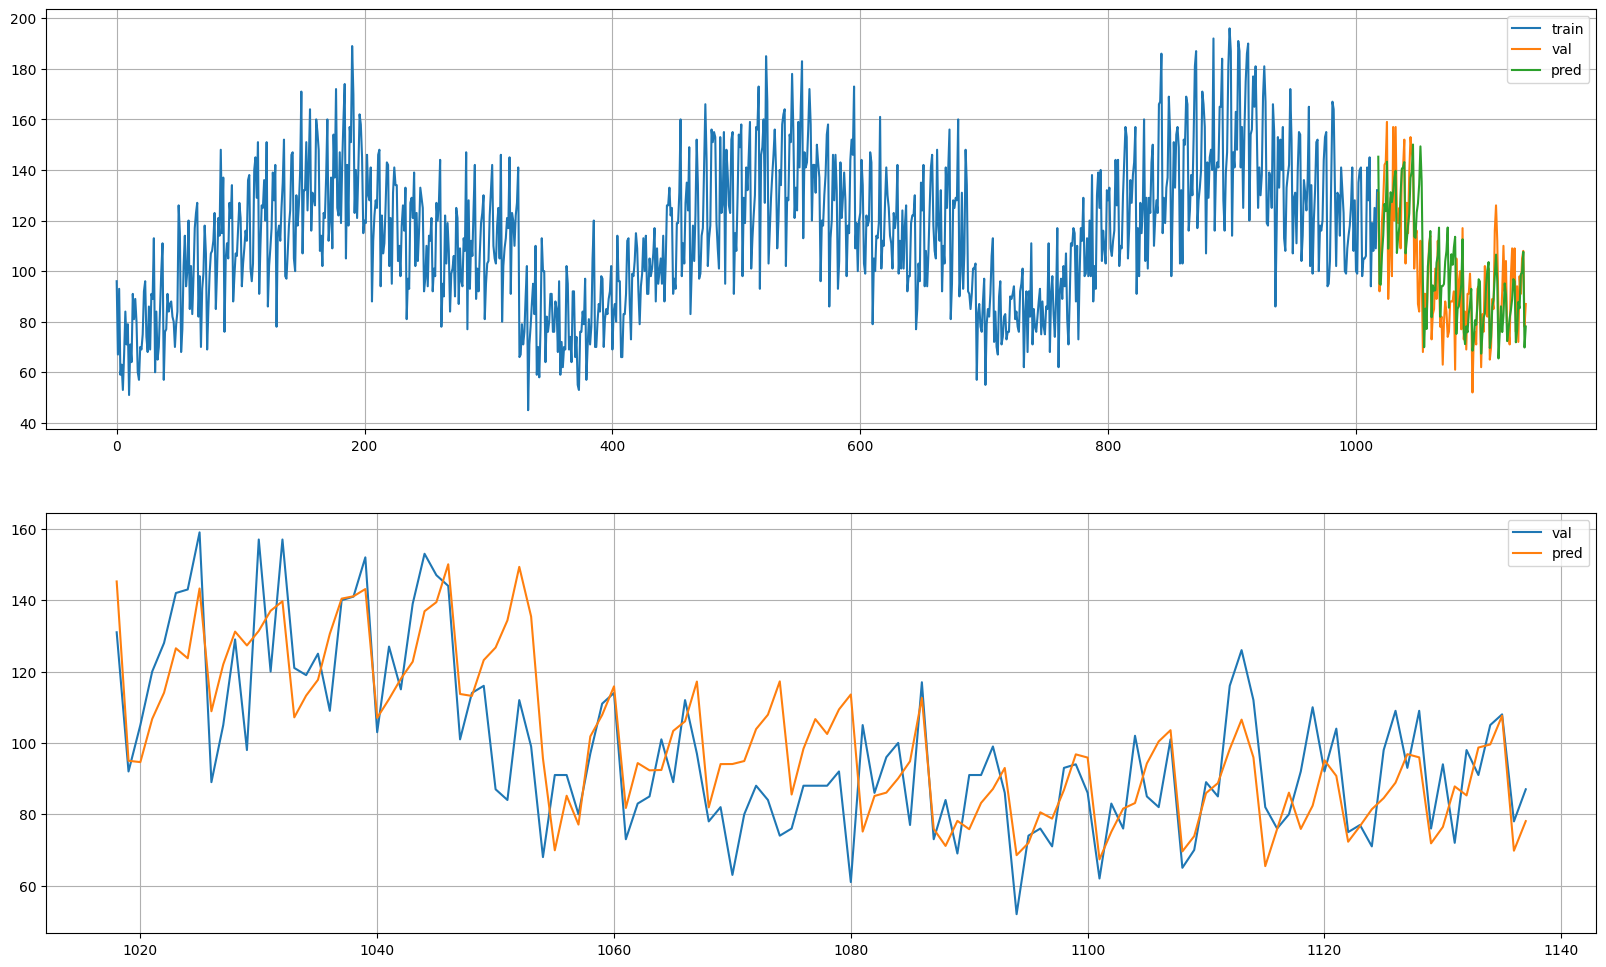

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
def preproc3d_test(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop([target], axis = 1)
    y = data.loc[:, target]

    col_names = list(x)

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    return x3, y3, scaler, y_min, y_max

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def pipeline_03(data_list):
    oil_price, orders, sales, products, stores = data_list[0], data_list[1], data_list[2], data_list[3], data_list[4]

    df = pd.merge(sales, oil_price, how = 'left', on = 'Date')
    df = pd.merge(df, orders, how = 'left', on = ['Date', 'Store_ID'])
    df = pd.merge(df, stores, how = 'left', on = 'Store_ID')
    df = pd.merge(df, products, how = 'left', on = 'Product_ID')

    df_3 = df[(df['Product_ID']==3) & (df['Store_ID']==44)]

    drop_cols = ['Store_ID', 'Product_ID', 'City', 'State', 'Store_Type', 'Product_Code', 'SubCategory', 'Category']

    df_3.drop(columns=drop_cols, axis=1, inplace=True)

    # 주말 여부 계산
    df_3['Weekend'] = df_3['Date'].dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    # 공휴일 여부 계산
    cal = calendar()
    holidays = cal.holidays(start=df_3['Date'].min(), end=df_3['Date'].max())
    df_3['Holiday'] = df_3['Date'].isin(holidays)

    # Black Friday 여부 계산
    # 추수감사절은 11월 넷째 목요일이므로, Black Friday는 그 다음날 금요일
    # 추수감사절은 11월 넷째 목요일
    def get_fourth_thursday_of_november(year):
        november_first = pd.Timestamp(year=year, month=11, day=1)
        fourth_thursday = (november_first + pd.offsets.Day((3 - november_first.weekday()) % 7)
                        + pd.offsets.Week(3))
        return fourth_thursday

    df_3['B_Friday'] = df_3['Date'].apply(lambda x: x == get_fourth_thursday_of_november(x.year) + pd.Timedelta(days=1))


    df_3['Total_sales'] = df_3['Qty'] * df_3['Price']

    df_3['target'] = df_3['Qty'].shift(-2)
    df_3.drop(columns=['LeadTime'], axis=1, inplace=True)

    df_3 = df_3.reset_index(drop=True)

    df_3.loc[df_3['Qty'] == 0.0, 'CustomerCount'] = 0.0
    df_3['CustomerCount'] = df_3['CustomerCount'].interpolate(method='linear')

    df_3['WTI_Price'] = df_3['WTI_Price'].interpolate(method='linear')
    df_3['WTI_Price'].fillna(method='bfill', inplace=True)

    df_3.dropna(axis=0, inplace=True)

    bool_columns = df_3.select_dtypes(include=['bool']).columns
    df_3[bool_columns] = df_3[bool_columns].astype(int)

    df_3.drop(columns=['Date'], inplace=True)

    timesteps = 7

    return preproc3d_test(df_3, timesteps, True)

In [ ]:
def pipeline_12(data_list):
    oil_price, orders, sales, products, stores = data_list[0], data_list[1], data_list[2], data_list[3], data_list[4]

    df = pd.merge(sales, products, on='Product_ID')

    df_12 = df[(df['Store_ID'] == 44) & (df['Product_ID'] == 12)]

    state_df = pd.merge(df, stores, on='Store_ID')
    state_df_milk = state_df[state_df['Product_ID'] == 12]
    df_12_season = df_12.copy()

    df_12_season['Season'] = df_12_season['Date'].dt.month.apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Autumn' if x in [9, 10, 11] else 'Winter')))
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')

    df_12_season_oil = pd.merge(df_12_season, oil_price, on='Date')

    df_12_season = df_12.copy()

    df_12_season['Season'] = df_12_season['Date'].dt.month.apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Autumn' if x in [9, 10, 11] else 'Winter')))
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method='bfill')
    df_12_season_oil = pd.merge(df_12_season, oil_price, on='Date')
    df_12_season_oil.drop(columns=['Product_ID', 'Store_ID', 'Product_Code', 'SubCategory', 'Category', 'LeadTime', 'Price'], inplace=True)

    df_12_season_oil_final = df_12_season_oil.copy()

    df_12_season_oil_final['Year'] = df_12_season_oil_final['Date'].dt.year
    df_12_season_oil_final['Month'] = df_12_season_oil_final['Date'].dt.month
    df_12_season_oil_final['Day'] = df_12_season_oil_final['Date'].dt.day

    df_12_season_oil_final_encoded = pd.get_dummies(df_12_season_oil_final['Season'])
    df_12_season_oil_final = pd.concat([df_12_season_oil_final, df_12_season_oil_final_encoded], axis=1)
    df_12_season_oil_final.drop(columns=['Season', 'Date'], inplace=True)

    df_12_season_oil_final['target'] = df_12_season_oil_final['Qty'].shift(-2)
    df_12_season_oil_final.dropna(inplace=True)
    print(df_12_season_oil_final)
    df_12_season_oil_final['Spring'] = df_12_season_oil_final['Spring'].replace({True: 1, False: 0})
    df_12_season_oil_final['Autumn'] = 0
    df_12_season_oil_final['Summer'] = 0
    df_12_season_oil_final['Winter'] = 0
    timesteps = 7
    return preproc3d_test(df_12_season_oil_final, timesteps, True)

In [ ]:
def pipeline_42(data_list):
    oil_price, orders, sales, products, stores = data_list[0], data_list[1], data_list[2], data_list[3], data_list[4]
    df_42=sales[(sales['Store_ID']==44)&(sales['Product_ID']==42)]

    or44=orders[orders['Store_ID']==44]
    df_42=pd.merge(df_42,or44)

    df_42['Year']=df_42['Date'].dt.year
    df_42['Month']=df_42['Date'].dt.month
    df_42['Day']=df_42['Date'].dt.day
    df_42['Day_of_week']=df_42['Date'].dt.weekday
    df_42['Day_of_week_2']=df_42['Date'].dt.weekday.shift(-2)

    df_42['isSummer'] = df_42['Month'].isin([6, 7, 8]).astype(int)
    df_42['isWinter'] = df_42['Month'].isin([1, 2, 12]).astype(int)

    df_42.drop(['Store_ID','Product_ID'],axis=1,inplace=True)

    df_42['target'] = df_42['Qty'].shift(-2)
    df_42 = df_42.iloc[:-2]
    df_42.drop(columns=['Date'], inplace=True)



    timesteps = 7

    return preproc3d_test(df_42, timesteps, True)

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
test_data_list = [oil_price_test, orders_test, sales_test, products, stores]

In [ ]:
x_test_03, y_test_03, scaler_03, y_min_03, y_max_03 = pipeline_03(test_data_list)
y_min_03, y_max_03, x_test_03.shape

(6195.0, 21278.0, (23, 7, 8))

In [ ]:
x_test_12, y_test_12, scaler_12, y_min_12, y_max_12 = pipeline_12(test_data_list)
y_min_12, y_max_12, x_test_12.shape

        Qty  WTI_Price  Year  Month  Day  Spring   target
0   11307.0      53.82  2017      3    1    True  11207.0
1    9761.0      52.63  2017      3    2    True   8985.0
2   11207.0      53.33  2017      3    3    True   8678.0
3    8985.0      53.19  2017      3    6    True   8965.0
4    8678.0      52.68  2017      3    7    True   8208.0
5    8965.0      49.83  2017      3    8    True   9083.0
6    8208.0      48.75  2017      3    9    True   8715.0
7    9083.0      48.05  2017      3   10    True   7505.0
8    8715.0      47.95  2017      3   13    True  10453.0
9    7505.0      47.24  2017      3   14    True   8592.0
10  10453.0      48.34  2017      3   15    True  11463.0
11   8592.0      48.30  2017      3   16    True   9052.0
12  11463.0      48.34  2017      3   17    True   8945.0
13   9052.0      47.79  2017      3   20    True   9165.0
14   8945.0      47.02  2017      3   21    True   8075.0
15   9165.0      47.29  2017      3   22    True   9876.0
16   8075.0   

(5459.0, 12173.0, (15, 7, 9))

In [ ]:
x_test_42, y_test_42, scaler_42, y_min_42, y_max_42  = pipeline_42(test_data_list)
y_min_42, y_max_42, x_test_42.shape

(89.0, 152.0, (23, 7, 9))

* 예측해보기

In [ ]:
pred_lstm_03 = model_lstm_03.predict(x_test_03)
pred_lstm_03 = pred_lstm_03 * (y_max_03 - y_min_03) + y_min_03
y_test_lstm_03_2 = y_test_03 * (y_max_03 - y_min_03) + y_min_03

print('MAE : ', mean_absolute_error(y_test_lstm_03_2, pred_lstm_03))
print('MAPE : ',mean_absolute_percentage_error(y_test_lstm_03_2, pred_lstm_03))
print('R2 : ',r2_score(y_test_lstm_03_2, pred_lstm_03))

1/1 [==============================] - 0s 113ms/step
MAE :  2619.331988790761
MAPE :  0.21758626872765122
R2 :  0.3153534815302512


In [ ]:
pred_cnn_03 = model_cnn_03.predict(x_test_03)
pred_cnn_03 = pred_cnn_03 * (y_max_03 - y_min_03) + y_min_03
y_test_cnn_03_2 = y_test_03 * (y_max_03 - y_min_03) + y_min_03

print('MAE : ', mean_absolute_error(y_test_cnn_03_2, pred_cnn_03))
print('MAPE : ',mean_absolute_percentage_error(y_test_cnn_03_2, pred_cnn_03))
print('R2 : ',r2_score(y_test_cnn_03_2, pred_cnn_03))

1/1 [==============================] - 0s 32ms/step
MAE :  1835.9380944293478
MAPE :  0.16055794901019754
R2 :  0.6873365108888231


In [ ]:
pred_lstm_12 = model_lstm_12.predict(x_test_12)
pred_lstm_12 = pred_lstm_12 * (y_max_12 - y_min_12) + y_min_12
y_test_lstm_12_2 = y_test_12 * (y_max_12 - y_min_12) + y_min_12

print('MAE : ', mean_absolute_error(y_test_lstm_12_2, pred_lstm_12))
print('MAPE : ',mean_absolute_percentage_error(y_test_lstm_12_2, pred_lstm_12))
print('R2 : ',r2_score(y_test_lstm_12_2, pred_lstm_12))

1/1 [==============================] - 0s 101ms/step
MAE :  2651.928678385417
MAPE :  0.278370997789757
R2 :  -2.5291411022174834


In [ ]:
pred_cnn_12 = model_cnn_12.predict(x_test_12)
pred_cnn_12 = pred_cnn_12 * (y_max_12 - y_min_12) + y_min_12
y_test_cnn_12_2 = y_test_12 * (y_max_12 - y_min_12) + y_min_12

print('MAE : ', mean_absolute_error(y_test_cnn_12_2, pred_cnn_12))
print('MAPE : ',mean_absolute_percentage_error(y_test_cnn_12_2, pred_cnn_12))
print('R2 : ',r2_score(y_test_cnn_12_2, pred_cnn_12))

1/1 [==============================] - 0s 31ms/step
MAE :  2191.213313802083
MAPE :  0.23366228770732328
R2 :  -1.5491310699498508


In [ ]:
pred_lstm_42 = model_lstm_12.predict(x_test_42)
pred_lstm_42 = pred_lstm_42 * (y_max_42 - y_min_42) + y_min_42
y_test_lstm_42_2 = y_test_42 * (y_max_42 - y_min_42) + y_min_42

print('MAE : ', mean_absolute_error(y_test_lstm_42_2, pred_lstm_42))
print('MAPE : ',mean_absolute_percentage_error(y_test_lstm_42_2, pred_lstm_42))
print('R2 : ',r2_score(y_test_lstm_42_2, pred_lstm_42))

1/1 [==============================] - 0s 19ms/step
MAE :  16.611573260763418
MAPE :  0.1370650977086414
R2 :  -0.8696506297816524


In [ ]:
pred_cnn_42 = model_cnn_42.predict(x_test_42)
pred_cnn_42 = pred_cnn_42 * (y_max_42 - y_min_42) + y_min_42
y_test_cnn_42_2 = y_test_42 * (y_max_42 - y_min_42) + y_min_42

print('MAE : ', mean_absolute_error(y_test_cnn_42_2, pred_cnn_42))
print('MAPE : ',mean_absolute_percentage_error(y_test_cnn_42_2, pred_cnn_42))
print('R2 : ',r2_score(y_test_cnn_42_2, pred_cnn_42))

1/1 [==============================] - 0s 19ms/step
MAE :  13.865474535071332
MAPE :  0.13120758411371453
R2 :  0.011666484282381817


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [ ]:
safe_stock = 500
#23846
#24390
result_lstm_03 = inv_simulator(y_test_lstm_03_2, pred_lstm_03, safe_stock, 8)
result_lstm_03

일평균 재고량     : 6745.119
일평균 재고 금액  : 53960.952
일평균 재고회전율 : 1.553
기회손실 수량     : -36069.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,10219.0,9316,500,11552,8816,0.0
1,10087.0,10395.0,10587,500,12215,10087,0.0
2,15131.0,11552.0,12052,0,10890,11552,-3079.0
3,18556.0,12215.0,12215,0,9919,12215,-6341.0
4,8803.0,10390.0,10890,2087,8074,10890,0.0
5,8690.0,9419.0,12006,3316,7853,9919,0.0
6,9199.0,9661.0,11390,2191,9669,8074,0.0
7,8148.0,10669.0,10044,1896,10798,7853,0.0
8,11616.0,11360.0,11565,0,13252,9669,-51.0
9,16510.0,12194.0,10798,0,11494,10798,-5712.0


In [ ]:
safe_stock = 19852
result_cnn_03 = inv_simulator(y_test_cnn_03_2, pred_cnn_03, safe_stock, 8)
result_cnn_03

일평균 재고량     : 26690.0
일평균 재고 금액  : 213520.0
일평균 재고회전율 : 0.507
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,9176.0,28668,19852,14007,8816,0.0
1,10087.0,10819.0,29939,19852,14312,10087,0.0
2,15131.0,14007.0,33859,18728,11889,14007,0.0
3,18556.0,14312.0,33040,14484,15271,14312,0.0
4,8803.0,10765.0,26373,17570,11545,11889,0.0
5,8690.0,9903.0,32841,24151,4822,15271,0.0
6,9199.0,9263.0,35696,26497,4037,11545,0.0
7,8148.0,9121.0,31319,23171,10839,4822,0.0
8,11616.0,10682.0,27208,15592,19250,4037,0.0
9,16510.0,14158.0,26431,9921,21129,10839,0.0


In [ ]:
safe_stock = 5751
result_lstm_12 = inv_simulator(y_test_lstm_12_2, pred_lstm_12, safe_stock, 6)
result_lstm_12

일평균 재고량     : 8182.962
일평균 재고 금액  : 49097.772000000004
일평균 재고회전율 : 1.236
기회손실 수량     : -1126.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8715.0,6523.0,14466,5751,6670,8715,0.0
1,7505.0,6575.0,13256,5751,6754,7505,0.0
2,10453.0,6670.0,12421,1968,10315,6670,0.0
3,8592.0,6754.0,8722,130,12094,6754,0.0
4,11463.0,6532.0,10445,0,12027,10315,-1018.0
5,9052.0,6473.0,12094,3042,9116,12094,0.0
6,8945.0,6276.0,15069,6124,6132,12027,0.0
7,9165.0,6407.0,15240,6075,6248,9116,0.0
8,8075.0,6505.0,12207,4132,8314,6132,0.0
9,9876.0,6572.0,10380,504,11909,6248,0.0


In [ ]:
safe_stock = 6040
result_cnn_12 = inv_simulator(y_test_cnn_12_2, pred_cnn_12, safe_stock, 6)
result_cnn_12

일평균 재고량     : 9060.346
일평균 재고 금액  : 54362.076
일평균 재고회전율 : 1.125
기회손실 수량     : -1148.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8715.0,6552.0,14755,6040,7231,8715,0.0
1,7505.0,6779.0,13545,6040,6931,7505,0.0
2,10453.0,7231.0,13271,2818,9966,7231,0.0
3,8592.0,6931.0,9749,1157,11755,6931,0.0
4,11463.0,6744.0,11123,0,13551,9966,-340.0
5,9052.0,6872.0,11755,2703,10860,11755,0.0
6,8945.0,7511.0,16254,7309,6192,13551,0.0
7,9165.0,7523.0,18169,9004,4632,10860,0.0
8,8075.0,7461.0,15196,7121,6241,6192,0.0
9,9876.0,7596.0,11753,1877,11715,4632,0.0


In [ ]:
safe_stock = 118
#103
result_lstm_42 = inv_simulator(y_test_lstm_42_2, pred_lstm_42, safe_stock, 5)
result_lstm_42

일평균 재고량     : 166.095
일평균 재고 금액  : 830.475
일평균 재고회전율 : 0.831
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,110.0,96.0,228,118,96,110,0.0
1,101.0,96.0,219,118,95,101,0.0
2,131.0,96.0,214,83,131,96,0.0
3,145.0,95.0,178,33,179,95,0.0
4,90.0,96.0,164,74,140,131,0.0
5,110.0,94.0,253,143,72,179,0.0
6,107.0,96.0,283,176,40,140,0.0
7,108.0,97.0,248,140,75,72,0.0
8,136.0,98.0,180,44,170,40,0.0
9,119.0,97.0,119,0,216,75,0.0


In [ ]:
safe_stock = 64
result_cnn_42 = inv_simulator(y_test_cnn_42_2, pred_cnn_42, safe_stock, 5)
result_cnn_42

일평균 재고량     : 130.0
일평균 재고 금액  : 650.0
일평균 재고회전율 : 0.937
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,110.0,125.0,174,64,126,110,0.0
1,101.0,118.0,165,64,124,101,0.0
2,131.0,126.0,190,59,113,126,0.0
3,145.0,124.0,183,38,139,124,0.0
4,90.0,108.0,151,61,126,113,0.0
5,110.0,113.0,200,90,92,139,0.0
6,107.0,123.0,216,109,76,126,0.0
7,108.0,118.0,201,93,97,92,0.0
8,136.0,121.0,169,33,156,76,0.0
9,119.0,126.0,130,11,169,97,0.0
